<a href="https://colab.research.google.com/github/jeongwoning/starbucks/blob/master/Colab_Py37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

batch_size=64
learning_rate=0.002
num_epoch=40

In [ ]:
cifar_train=dset.CIFAR10("CIFAR10/", train=True,
                         transform=transforms.Compose([transforms.ToTensor(),
                                                       transforms.RandomHorizontalFlip(),
                                                       transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))]),
                         target_transform=None, download=True)
cifar_test=dset.CIFAR10("CIFAR10/", train=False,
                        transform=transforms.Compose([transforms.ToTensor(),
                                                      transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))]),
                        target_transform=None, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cifar_train 길이: 50000
cifar_test 길이: 10000
image data 형태: torch.Size([3, 32, 32])
label: 9


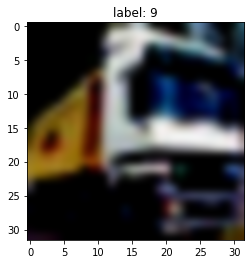

In [ ]:
print("cifar_train 길이:", len(cifar_train))
print("cifar_test 길이:", len(cifar_test))

image, label = cifar_train.__getitem__(1)
print("image data 형태:", image.size())
print("label:", label)

img = image.numpy()

r,g,b = img[0,:,:], img[1,:,:], img[2,:,:]
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r,g,b

plt.title("label: %d" %label)
plt.imshow(img2, interpolation='bicubic')
plt.show()

In [ ]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0

    for j, [imgs, labels] in enumerate(dloader):
        img = Variable(imgs, volatile=True).cuda()
        label = Variable(labels).cuda()

        output = imodel.forward(img)
        _, output_index = torch.max(output, 1)

        total += label.size(0)
        correct += (output_index == label).sum().float()

    print("Accuracy of Test Data: {}".format(100*correct/total))

In [ ]:
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,8,3,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            #nn.Dropout2d(0.5),
            nn.Conv2d(8,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout2d(0.5),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*8*8,500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(500,10)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self,x):
        out=self.layer(x)
        out=out.view(batch_size,-1)
        out=self.fc_layer(out)

        return out
model=CNN().cuda()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [ ]:
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

model.train()
for i in range(num_epoch):
    for j,[image, label] in enumerate(train_loader):
        x=Variable(image).cuda()
        y_=Variable(label).cuda()

        optimizer.zero_grad()
        output=model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()

        if j%1000==0:
            print(j,loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0 tensor(3.3733, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.8655, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.7336, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.7687, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.8360, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.6847, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.4367, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.4906, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.4395, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.5198, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.3751, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.6306, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.2712, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.4990, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.4107, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor(1.4541, device='cuda:0', grad_fn=<NllLossBackward0>)
0 tensor

In [ ]:
model.eval()
ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy of Test Data: 79.03646087646484


In [ ]:
netname = './nets/hjw_net01.pkl'
torch.save(model, netname, )

In [ ]:
netname = './nets/hjw_net01.pkl'
model = torch.load(netname)

ComputeAccr(test_loader, model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy of Test Data: 79.03646087646484
